In [ ]:
# default_exp frequencer

# Frequencer

> Simple tool for frequency measurements.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import pandas as pd
import numpy as np
import scipy as sp
import scipy.fftpack as spfp
from scipy import signal

import matplotlib.pyplot as plt

from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf

In [ ]:
#export
class frequencer:
    def __init__(self, x, y, interval):
        self.x = list(x)
        self.y = list(y)
        self.interval = interval # interval between frames in SECONDS

    def smooth(self, window:int = 35, poly:int = 11) -> np.ndarray:
        return sp.signal.savgol_filter(self.y, window, poly)

    def fig_init(self, dpi:int, figsize:tuple, X:str, Y:str, xlim:list) -> plt.Figure:
        '''
        Create figure object with given parameters
        '''
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plt.xlim(xlim) 
        plt.ylim([0,1])
        plt.xlabel(X)
        plt.ylabel(Y)
        return fig
    
    def plot(self):
        '''
        Plot full graph of oscillations
        '''
        fig = plt.figure(dpi=100, figsize=(20,4))
        plt.plot(self.x, self.y, linewidth=0.5)
        plt.xlabel("Time, sec", size=12) 
    
    def find_step(self, plot:bool = True) -> int:
        '''
        Find the function step with convolution, if any. 
        
        plot - enable plotting graph.
        '''
        array = np.array(self.y)
        array -= np.average(array)
        step = np.hstack((np.ones(len(array)), -1*np.ones(len(array))))
        array_step = np.convolve(array, step, mode='valid')
        array_step_norm = np.divide(array_step, array_step.max())

        step_idx = np.argmax(array_step_norm)

        if plot:
            plt.plot(self.y)
            plt.plot(array_step_norm)
            
        return step_idx

    def autocorr_freq(self, section:tuple = (0,20), lags:int = 100, plot:bool = True):
        '''
        Right way to measure frequency, autocorrelation function. No matter what type of hesitationoscillations you have, 
        sinusoidal, squared, sawtooth, whatever.

        Parameters:
        section - time interval for measurements (in seconds).
        lags - number of autocorrelation shifts.
        plot - enable plotting graph.
        '''
        s=[int(i/self.interval) for i in section]
        correlation = acf(self.y[s[0]:s[1]], nlags=lags, fft=False)

        sorder = np.diff(np.sign(np.diff(correlation))) 
        peaks = (sorder < 0).nonzero()[0] + 1 
        inter = np.diff(peaks)

        print("Frequency is: ~{:.3f} Hz".format(1/(np.average(inter)*self.interval)))
        
        if plot:
            fig, axs = plt.subplots(dpi=100, figsize=(10,3))
            tsaplots.plot_acf(self.y[s[0]:s[1]], lags=lags)
            plt.plot(correlation)
            plt.xlabel("Number of autocorr shifts")
            axs.plot(self.x[s[0]:s[1]], self.y[s[0]:s[1]], linewidth=0.5)
            axs.set_title('Section of frequency measurement')
            axs.set_xlabel('Time, sec')

Read our data, every column in this .csv file represents a random oscillations with a step in the middle.

In [ ]:
freqs = pd.read_csv(r'test_freqfile/test_oscillations.csv')

Let's create object of our `frequencer` class from column with random oscillations.

We will pass the values for x and y and the interval between each point.

In [ ]:
test3 = frequencer(freqs.index, freqs.iloc[:,2], 0.05)

Now we can plot our test fluctuation with `plot` method.

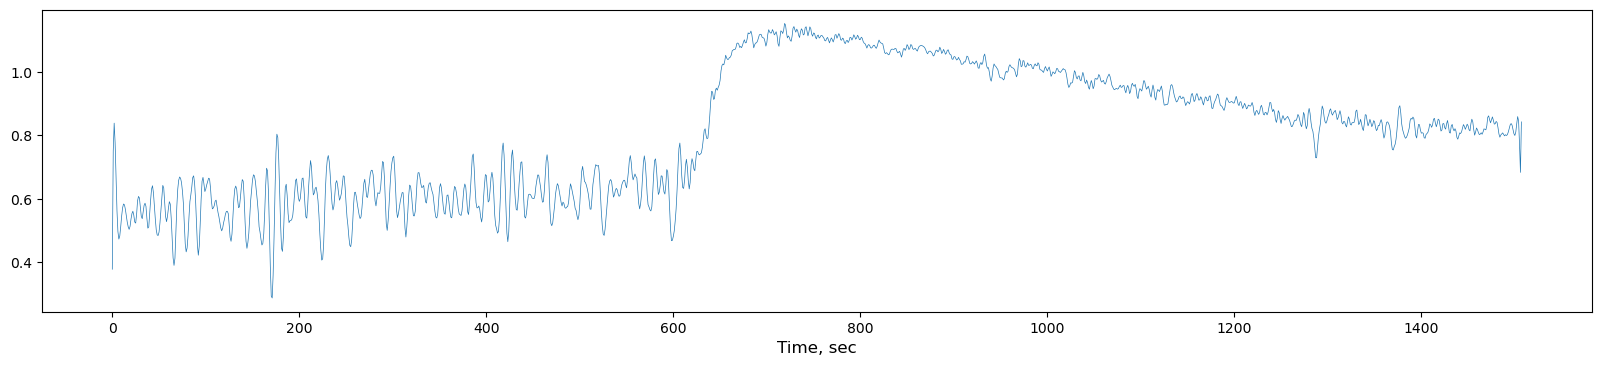

In [ ]:
test3.plot()

Let's measure frequency of oscillations with `autocorr_freq` method. It prints frequency value, plots chosen section of oscillations and autocorrelation plot.

Frequency is: ~1.951 Hz


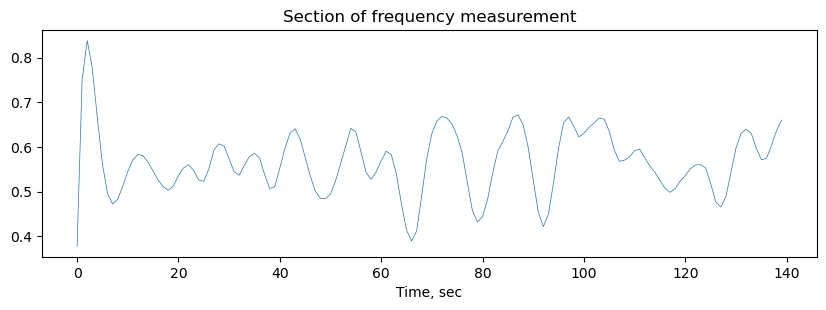

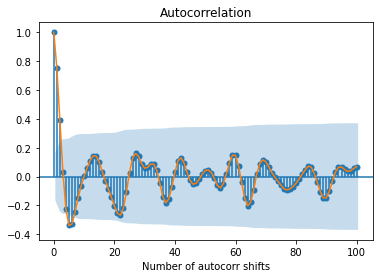

In [ ]:
test3.autocorr_freq(section=(0,7))

Also we can find step with `find_step` method, if any. It prints index of step value and plots graph with convolution function.

638

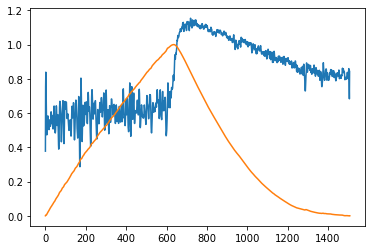

In [ ]:
test3.find_step()

Some tests:

In [ ]:
assert test3.find_step(plot=False) == 638